# Assignment 09: Final Project (Machine Learning EEG)
## Computational Methods in Psychology and Neuroscience
### Psychology 4215/7215 --- Fall 2023


## Brief overview

This project will consist of a deeper dive into EEG analysis by first preprocessing a new subject from the same dataset we analyzed for class. Then you will organize the data and perform a machine-learning analysis to test whether it it possible to distinguish, above chance, whether the participant experienced an auditory or visual stimulus. 


## EEG Preprocessing

For the preprocessing, you will simply replicate everything we did in class, but on the new data from participant `rof011`. Here's the link to download the EEG data (note it is large, at ~220MB):

https://virginia.box.com/s/j1gdv020kdfyitsho7cmp81oc6ymw9ih

Then you'll follow along for all steps of data preprocessing that we covered in the class lecture on EEG data:

https://github.com/compmem/compsy/blob/2023_Fall/lessons/13_EEG.ipynb

In particular you will need to:

1) Load in the behavioral data
2) Load in the EEG data
3) Align the EEG and behavioral data via the sync pulses
4) Perform eyeblink correction with ICA
5) Extract the epochs/events from the continuous data
6) Make some simple plots to visualize the event-related potentials (ERPs)

At the end of this process you'll have the Epoch data in a form that should work well for a machine learning analysis.

## Machine Learning of EEG data

Making use of the Epochs of data, you will first follow along as we assess whether we can distinguish between `common` and `rare` trials based on the EEG voltage values recorded during each trial.

You will then apply the same general approach to try and classify whether the participant was experiencing a `visual` or `auditory` stimulus at each trial. 




## You'll need both MNE and sklearn (will come with nilearn)

```bash
conda install -c conda-forge mne

# or install via pip

python -m pip install mne[hdf5]
```
and also:
```bash
python -m pip install pyyaml

```

and for nilearn:

```bash
conda install -c conda-forge nilearn

# or install it via pip

python -m pip instal nilearn
```

## EEG Preprocessing

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import mne


In [ ]:
# YOUR CODE IN SEPARATE CELLS HERE TO PREPROCESS THE NEW DATASET


## Machine Learning

We'll first make use of the Epochs of data from the participant analyzed in class in order to demonstrate manipulating the data.

In [209]:
# necessary imports from sklearn
from sklearn import svm
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import StratifiedKFold, permutation_test_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, ElasticNet

In [37]:
# load in the epochs of data (same as your homework)
epochs = mne.read_epochs('rof07_odd-epo.fif')

# downsample to 50 Hz
epochs = epochs.resample(sfreq=50)

Reading /home/per/OneDrive/class/compsy/assignments/rof07_odd-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     995.00 ms
        0 CTF compensation matrices available
Not setting metadata
400 matching events found
No baseline correction applied
0 projection items activated


### Extracting the data and event labels

- We would like to train and test a machine learning classifier to predict what the participant is experiencing during each trial. 

- We will use the voltage values for each event (at each of the 64 channels as function of time) as the data for predicting the event type, which is also called the `label`.

- The next section extracts the conditions of interest (in this case `common` or `rare`, and defines the labels for each trial

In [95]:
# this will extract the EEG data for each epoch type
# shape is event, electrode, time
vdata = epochs['common'].get_data()
adata = epochs['rare'].get_data()

# combine them
all_data = np.vstack([vdata, adata])

# create labels for each epoch
labels = ['common']*len(vdata) + ['rare']*len(adata)

# show the data 
all_data.shape

/tmp/ipykernel_2394948/698547697.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  vdata = epochs['common'].get_data()
/tmp/ipykernel_2394948/698547697.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  adata = epochs['rare'].get_data()


(400, 64, 60)

In [96]:
# machine learning involves decoding samples based on features
# so we need our data to be in that shape

# the first dimension is already the samples, 
# but the electrodes and time are the features that we can reshape

X = all_data.reshape((len(all_data), -1))
X.shape

(400, 3840)

In [101]:
# we also need to turn the labels into integers
le = LabelEncoder()
y = le.fit_transform(labels)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Training and Testing

- To be valid, you have to train and test a classifer on different data.
- We can approximate this within a single dataset, but created subsets of our data for training and testing (this is called cross validation)
- Below we set up a classifer and then train and test it on each subset (or fold) of the data.
- We also extract the weights so we can see what features drove the testing performance

In [225]:
# set up a classifier
clf = svm.LinearSVC(penalty='l2', dual='auto', max_iter=10000)

# set up cross validation that saves out equal numbers of
# each category
cv = StratifiedKFold(10, shuffle=True)

# perform cross validation saving performance and weights
perfs = []
weights = []
for train_index, test_index in cv.split(X, y):
    # select the training and testing samples
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # handle unbalanced training set
    sample_weight = compute_sample_weight('balanced', y=y_train)

    # Train the classifier
    clf.fit(X_train, y_train, sample_weight=sample_weight)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy and store it
    perfs.append(accuracy_score(y_test, y_pred))

    # Store the weights of this fold
    weights.append(clf.coef_)
    
# stack the weights
weights = np.vstack(weights)
print(perfs)
print('mean accuracy:', np.mean(perfs))

[0.55, 0.8, 0.8, 0.475, 0.575, 0.2, 0.8, 0.2, 0.35, 0.775]
mean accuracy: 0.5525


### Fluctuating performance

- You can see above that the performance of the classifier varies wildly from fold to fold due to fluctuations in the test data
- What happens if you re-run the cell above?
- We can get an overall assessment of performance by averaging across folds

### Features that guided performance

- Next we'll extract the weights from the classifier that guided its decisions

Index with max std: 32


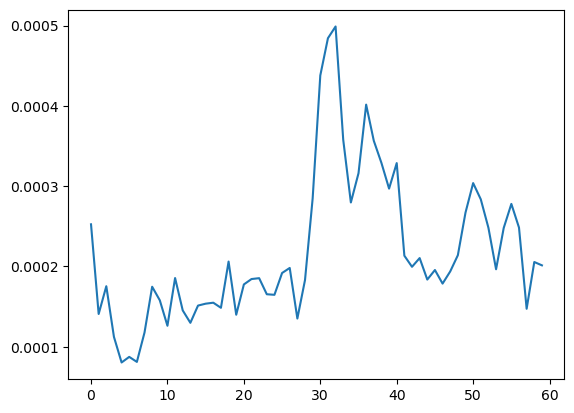

In [226]:
# calculate the average weights and reshape to channels by time
ave_weights = weights.mean(0).reshape(all_data.shape[1:]);

# find the time points with the highest std across electrodes
plt.plot(ave_weights.std(0))

# extract the max ind
ind = ave_weights.std(0).argmax()
print('Index with max std:', ind)

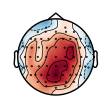

Map at 0.44 s


In [227]:
mne.viz.plot_topomap(data=ave_weights[:, ind], pos=epochs.info);
print('Map at %0.2f s'%epochs.times[ind])

## Your turn!!!

- In a set of cells below, you should now test whether you can classify whether the participant was experiencing an `auditory` or `visual` stimulus.

- Test this in both participants (`rof07` and `rof11`)

- Make sure to include all the relevant plots and performance assessments, as above


## Discussion

Once you have completed the machine-learning analysis of the EEG data, please write a handful of bullet points summarizing what you found (i.e., was the machine learning accuracy above chance? how do you know this? what features helped the model make this decision?, was classification performance better in one participant than the other? did the topomaps of the weights differe between subjects?, etc.)